### NAO correlations with energy variables ###

Exploring how well the NAO correlates with energy variables on seasonal to decadal timescales during the winter (ONDJFM, DJFM, or DJF). Using the following datasets:

* CLEARHEADS - ERA5-derived energy time series, includes offshore wind in EEZs and Heating Degree Days.
* ERA5 - reanalysis product for deriving the NAO indices at different timescales.
* ENTSO-E - shorter observed time series of capacity factors and other energy variables. For ground truthing the CLEARHEADS data above.

In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Import local modules
import sys
import os
import glob

# Import third-party modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import iris
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cdsapi
# import xesmf as xe
from datetime import datetime
from tqdm import tqdm
from scipy.stats import pearsonr

ERROR 1: PROJ: proj_create_from_database: Open of /apps/jasmin/jaspy/mambaforge_envs/jaspy3.10/mf-22.11.1-4/envs/jaspy3.10-mf-22.11.1-4-r20230718/share/proj failed


In [2]:
# Import the local functions
import functions_em as funcs_em

In [3]:
sys.path.append("/home/users/benhutch/energy-met-corr")
import dictionaries_em as dicts

sys.path.append("/home/users/benhutch/skill-maps/python")
import functions as fnc

### Testing scatter functions ###

In [4]:
# # /gws/nopw/j04/canari/users/benhutch/alternate-lag-processed-data/tas_ONDJFM_global_1961_2014_2-9_4_20_1709338673.215247_nao_matched_members.npy


# Dictionary for predictor var
pred_var_dict = {
    "lag": 4,
    "alt_lag": "nao_matched",
    "method": "nao_matched",
    "region": "global",
}

In [5]:
# test the function for loading the scatter data
dict = funcs_em.process_data_for_scatter(
    season="ONDJFM",
    forecast_range="2-9",
    start_year=1961,
    end_year=2014,
    predictor_var="sfcWind",
    predictor_var_dict=pred_var_dict,
    predictand_var="pr",
    predictand_var_file=dicts.regrid_file,
    region=dicts.scandi_box,
    region_name="uk",
)

The region is a dictionary.
Extracting the lats and lons from the region dictionary.
The predictor variable is not the NAO index.
Extracting the predictor variable from the predictor variable file.
Loading the nao matched data
More than one file found
Using the latest datetime file: /gws/nopw/j04/canari/users/benhutch/alternate-lag-processed-data/sfcWind_ONDJFM_global_1961_2014_2-9_4_20_1709332379.3200548_nao_matched_members.npy


/home/users/benhutch/skill-maps/python/nao_alt_lag_functions.py:172: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  datetimes = [pd.to_datetime(datetime, unit="s") for datetime in datetimes]


Shape of the data: (20, 51, 72, 144)


/home/users/benhutch/.local/lib/python3.10/site-packages/iris/coords.py:2237: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'time', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'time'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))


Time dimension of obs: ['1960-12-31T00:00:00.000000000' '1961-12-31T00:00:00.000000000'
 '1962-12-31T00:00:00.000000000' '1963-12-31T00:00:00.000000000'
 '1964-12-31T00:00:00.000000000' '1965-12-31T00:00:00.000000000'
 '1966-12-31T00:00:00.000000000' '1967-12-31T00:00:00.000000000'
 '1968-12-31T00:00:00.000000000' '1969-12-31T00:00:00.000000000'
 '1970-12-31T00:00:00.000000000' '1971-12-31T00:00:00.000000000'
 '1972-12-31T00:00:00.000000000' '1973-12-31T00:00:00.000000000'
 '1974-12-31T00:00:00.000000000' '1975-12-31T00:00:00.000000000'
 '1976-12-31T00:00:00.000000000' '1977-12-31T00:00:00.000000000'
 '1978-12-31T00:00:00.000000000' '1979-12-31T00:00:00.000000000'
 '1980-12-31T00:00:00.000000000' '1981-12-31T00:00:00.000000000'
 '1982-12-31T00:00:00.000000000' '1983-12-31T00:00:00.000000000'
 '1984-12-31T00:00:00.000000000' '1985-12-31T00:00:00.000000000'
 '1986-12-31T00:00:00.000000000' '1987-12-31T00:00:00.000000000'
 '1988-12-31T00:00:00.000000000' '1989-12-31T00:00:00.000000000'
 '

/home/users/benhutch/.local/lib/python3.10/site-packages/iris/coords.py:2237: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'time', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'time'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))


obs_anoms.shape = (51,)
data.shape = (20, 51, 72, 144)
obs_anoms.shape = (51,)
len valid_years = 51
modified model data.shape = (20, 51, 72, 144)
model data members.shape = (20, 51)


In [6]:
# # Loop over dict and print the keys
# for key in dict.keys():
#     print(key)

In [7]:
# # Plot the scatter data
# funcs_em.plot_scatter(
#     scatter_dict=dict,
# )

### Downloading ERA5 data ###

For calculating the NAO index, we want to query the CDS API for ERA5 data:

* From 1950-2023
* For ONDJFM
* Monthly-means

*Note - this data should be regridded before comparison with the CLEARHEADS/ENTSO-E data*

In [8]:
# # Set up a new client
# c = cdsapi.Client()

In [9]:
# # Set up the dictionary for the ERA5 request
# era5_request_dict = {
#     'variable': 'mean_sea_level_pressure',
#     'product_type': 'monthly_averaged_reanalysis',
#     'year': [x for x in map(str, range(1950, 2023))],
#     'month': [1, 2, 3, 10, 11, 12],
#     'format': 'netcdf',
#     'time': '00:00'
# }

# # Print the request dictionary
# print(era5_request_dict)

In [10]:
# # Set up the target directory
# target_dir = '/gws/nopw/j04/canari/users/benhutch/ERA5'

# # Assert that the target directory exists
# assert os.path.exists(target_dir)

# # Assert that the target directory is not empty
# assert len(os.listdir(target_dir)) > 0

# # Set up the target file
# target_file = os.path.join(target_dir, 'era5_mslp_monthly_1950_2022_ONDJFM.nc')

# # Print the target file
# print(target_file)

# # If the target file does not exist, download the data
# if not os.path.exists(target_file):
#     c.retrieve(
#         'reanalysis-era5-single-levels',
#         era5_request_dict,
#         target_file)
# else:
#     print('The target file already exists: {}'.format(target_file))

Now we want to plot the observed spatial correlations between the NAO and 10m wind speeds and precipitation.

In [11]:
# Test this function
stats_dict = funcs_em.calc_nao_spatial_corr(
    season="ONDJFM",
    forecast_range="2-9",
    start_year=1960,
    end_year=2023,
    corr_var="pr",
    nao_n_grid=dicts.uk_n_box_corrected,
    nao_s_grid=dicts.uk_s_box_corrected,
)

The obs variable is a wind speed variable
Loading regrid obs file using xarray:  /home/users/benhutch/ERA5/global_regrid_sel_region_var228.nc


/home/users/benhutch/.local/lib/python3.10/site-packages/iris/coords.py:2237: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'time', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'time'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))
/home/users/benhutch/.local/lib/python3.10/site-packages/iris/coords.py:2237: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'time', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'time'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))


Time dimension of obs: ['1960-12-31T00:00:00.000000000' '1961-12-31T00:00:00.000000000'
 '1962-12-31T00:00:00.000000000' '1963-12-31T00:00:00.000000000'
 '1964-12-31T00:00:00.000000000' '1965-12-31T00:00:00.000000000'
 '1966-12-31T00:00:00.000000000' '1967-12-31T00:00:00.000000000'
 '1968-12-31T00:00:00.000000000' '1969-12-31T00:00:00.000000000'
 '1970-12-31T00:00:00.000000000' '1971-12-31T00:00:00.000000000'
 '1972-12-31T00:00:00.000000000' '1973-12-31T00:00:00.000000000'
 '1974-12-31T00:00:00.000000000' '1975-12-31T00:00:00.000000000'
 '1976-12-31T00:00:00.000000000' '1977-12-31T00:00:00.000000000'
 '1978-12-31T00:00:00.000000000' '1979-12-31T00:00:00.000000000'
 '1980-12-31T00:00:00.000000000' '1981-12-31T00:00:00.000000000'
 '1982-12-31T00:00:00.000000000' '1983-12-31T00:00:00.000000000'
 '1984-12-31T00:00:00.000000000' '1985-12-31T00:00:00.000000000'
 '1986-12-31T00:00:00.000000000' '1987-12-31T00:00:00.000000000'
 '1988-12-31T00:00:00.000000000' '1989-12-31T00:00:00.000000000'
 '

In [12]:
# Extract the nao index
nao = stats_dict["nao"]

# Extract the corr var anomalies
corr_var_ts = stats_dict["corr_var_ts"]

In [13]:
# Print the shape of these
print(nao.shape)

# Print the shape of these
print(corr_var_ts.shape)

(56,)
(56, 72, 144)


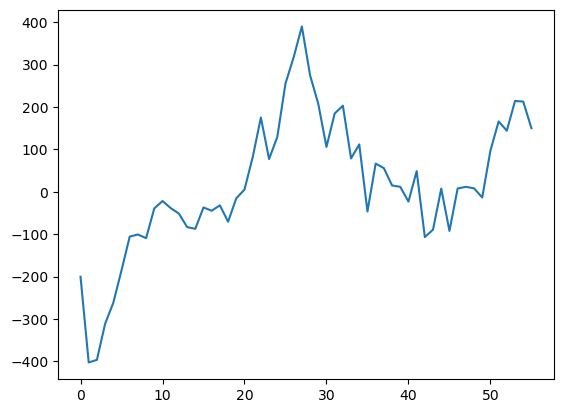

In [14]:
# Plot the nao index
plt.plot(nao)

Converting NAO index from Pa to hPa
Converting obs precip from m day-1 to mm day-1
Slope: 0.04650114082270912, Intercept: -0.004544733184812423


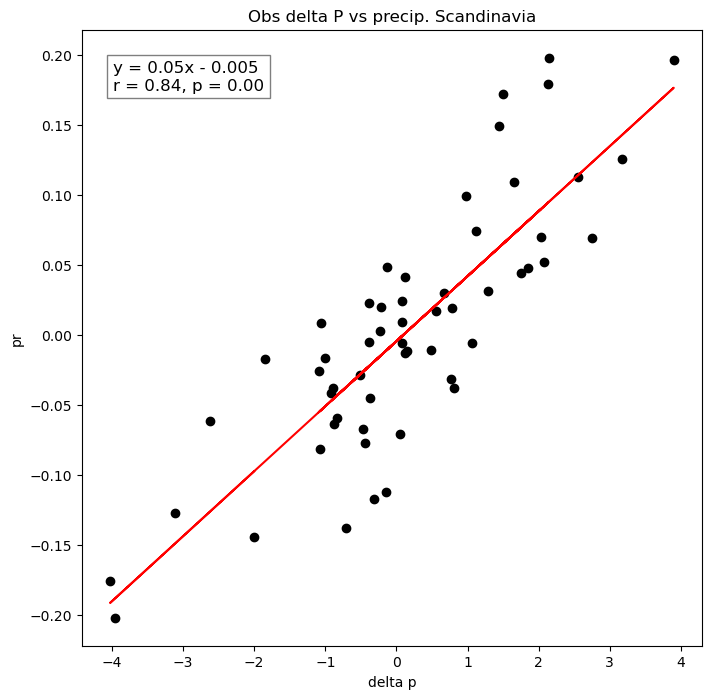

In [17]:
# Plot the scatter plot
df = funcs_em.plot_scatter_obs(
    index=nao,
    variable=corr_var_ts,
    lats=stats_dict["lats"],
    lons=stats_dict["lons"],
    index_name="delta p",
    variable_name="pr",
    plot_gridbox=dicts.scandi_box,
    title="Obs delta P vs precip. Scandinavia",
    show_eqn=True,
)

In [28]:
pd.set_option("display.float_format", "{:.10f}".format)

df.slope

0   0.0271106805
Name: slope, dtype: float64

In [29]:
# Set up a filename for the dataframe
dir = "/home/users/benhutch/energy-met-corr/coeffs"

# If the directory does not exist, create it
if not os.path.exists(dir):
    os.makedirs(dir)

# Set up the filename
filename = os.path.join(dir, "nao_pr_scandi_slope.csv")

# Save the dataframe
df.to_csv(filename)

In [ ]:
# Create an empty array with the correct shape
corr_array = np.empty([corr_var_ts.shape[1], corr_var_ts.shape[2]])  # lat  # lon

# Same for the p-values
pval_array = np.empty([corr_var_ts.shape[1], corr_var_ts.shape[2]])  # lat  # lon

# Loop over the lats
for lat in tqdm(range(corr_var_ts.shape[1])):
    # Loop over the lons
    for lon in range(corr_var_ts.shape[2]):
        # Extract the corr_var_ts for the lat and lon
        corr_var_anom_values_lat_lon = corr_var_ts[:, lat, lon]

        # Replace NaNs with 0
        corr_var_anom_values_lat_lon = np.nan_to_num(
            corr_var_anom_values_lat_lon, nan=0
        )

        # Calculate the correlation
        corr, pval = pearsonr(nao, corr_var_anom_values_lat_lon)

        # Assign the correlation to the array
        corr_array[lat, lon] = corr

        # Assign the p-value to the array
        pval_array[lat, lon] = pval

# Print the shape of the corr_array
print("shape of corr_array: ", corr_array.shape)
print("shape of pval_array: ", pval_array.shape)

In [ ]:
# Test the function
funcs_em.plot_corr(
    corr_array=corr_array,
    pval_array=pval_array,
    lats=stats_dict["lats"],
    lons=stats_dict["lons"],
    variable="psl",
    sig_threshold=0.05,
    plot_gridbox=[dicts.scandi_box],
    nao=stats_dict["nao"],
    corr_var_ts=stats_dict["corr_var_ts"],
)